# Analysis of Emergency Maternal Care Deprivation in Kano and Lagos, Nigeria
> Note: This notebook requires the local environment dependencies listed in our [requirements.txt](requirements.txt) file. Use this file to install the required packages in a virtual environment.

> To excecute OpenRouteService functions, it is required to install the [library dependencies](https://github.com/GIScience/openrouteservice-examples#local-installation).
> You should either have an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) or a local ORS environment to complete the analysis.

The model concepts and processes are described in our documentation. The [Dataset-interpretability](../kano/dataset-interpretability.md) file describes the rationale behind this model. 

##Workflow:

The notebook is divided into the following sections:
1. Initial Setup
2. Data Preparation
3. Travel time estimates
4. Two-step floating catchment area (2SFCA) analysis
5. Results



## 1. Initial Setup

## Setting up the virtual environment

```bash
# Create a new virtual environment
# It is recommended to create this virtual environment in the scripts folder
python -m venv .venv

# Activate the virtual environment
source .venv/bin/activate
pip install -r requirements.txt
```

## To run your notebook in VS Code

```bash
pip install -U ipykernel
python -m ipykernel install --user --name=.venv
```

In [41]:
import os
from IPython.display import display
import requests

import folium
from folium.plugins import MarkerCluster
import openrouteservice
import time

import time
import pandas as pd
import numpy as np
import fiona as fn
import geopandas as gpd
from shapely.geometry import shape, mapping
from shapely.geometry import Point
from shapely.geometry import box
from scipy.spatial import cKDTree
from tqdm import tqdm

import rasterio
from rasterio.transform import xy
from rasterio.mask import mask
import rasterstats as rs

import math

## Preprocessing
In this study, users first requested an ORS Matrix API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.


### Option 1: Using an ORS API Key
Make sure you have a .env file in the root directory with the following content:
```bash
    OPENROUTESERVICE_API_KEY='your_api_key'
```

In [ ]:
# Read the api key from the .env file
from dotenv import load_dotenv
%load_ext dotenv
%dotenv
api_key = os.getenv('OPENROUTESERVICE_API_KEY')
client = openrouteservice.Client(key=api_key)

### Option 2: Using a local ORS service
Make sure you have set a local service that runs the OSM-based ORS API. 
```r
    # Insert R code from the local ORS service
```

For this study different kind of data were used. The dataset on healthcare facilities is sourced from a research ([Macharia, P.M. et al., 2023](https://doi.org/10.1038/s41597-023-02651-9)) which provides A geospatial database of close-to-reality travel times to obstetric emergency care in 15 Nigerian conurbations. The dataset were filtered by state name to isolate facilities in Kano and converted CSV file to shapefile based on coordinates using [QGIS](https://qgis.org/). 

The Level 2 administrative boundary data is sourced from [Humanitarian Data Exchange](https://data.humdata.org/) were used to correlate the isochrones and healthcare facility distribution with specific administrative regions. The data were filtered based on the administrative region name (lganame) to focus the analysis on Kano.

Despite being official, administrative boundaries may not reflect the actual patterns of human settlement or economic activity. Therefore, the team used the Functional Urban Area (FUA) as a complementary definition of the study areas. The FUA is defined by [the Joint Research Centre of the European Commission](https://commission.europa.eu/about/departments-and-executive-agencies/joint-research-centre_en) as the actual urban sprawl and human activities, encompassing the core city and economically or socially integrated surrounding regions. The FUA was obtained from [the Global Human Settlement Layer (GHSL) ](https://human-settlement.emergency.copernicus.eu/)dataset, which provides spatial data for functional urban areas worldwide. 

* [Datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2) (15/07/2023)
* [Shapefile of district boundaries](https://data.humdata.org/dataset/nigeria-admin-level-2) - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Functional Urban Areas](https://human-settlement.emergency.copernicus.eu/download.php?ds=FUA) - data from Global Human Settlement Layer(2015)

### option 1: Kano
If you want to process data for the city of Kano, use the following code to filter the dataset. 


In [7]:
# Set paths to access data
# Define directories
data_inputs = '../scripts/data-inputs/'
data_temp = '../scripts/data-temp/'
data_outputs = '../scripts/data-outputs/'
model_outputs = '../kano/'

## 1. Data Collection

### Validated healthcare facilities
note: to describe the process to validate healthcare facilities

In [44]:
healthcare_facilities_validated = gpd.read_file(data_inputs + 'health-care-facilities-validated-Apr2025.geojson')

In [4]:
healthcare_facilities_validated

,orig_order,state,lga,ward,urban_conurb,uid,facility_code,ontime_code,facility_name,reg_number,...,latitude,longitude,operation_status,registration_status,license_status,created,last_updated,last_updated_ontime,hcf_id,geometry
0,117,1,Agege,Dopemu,1,25250613.0,24/01/1/2/2/0001,100101001,Al-Imaan Hospital and Maternity Home,None,...,6.61300,3.31549,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,1,POINT (3.31549 6.613)
1,400,1,Agege,Keke,1,58886840.0,24/01/1/2/2/0009,100101002,J.A Lashman Hospital,None,...,6.62262,3.33436,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-28 10:09:17,28/09/2022 09:00,2,POINT (3.33436 6.62262)
2,399,1,Agege,Orile (Agege),1,70566198.0,24/01/1/2/1/0001,100101003,Orile Agege General Hospital,None,...,6.63477,3.30360,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,3,POINT (3.3036 6.63477)
3,118,1,Agege,Powerline,1,81930847.0,24/01/1/2/2/0016,100101004,Molayo Medical Centre,None,...,6.63309,3.31291,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 10:30:39,28/09/2022 09:00,4,POINT (3.31291 6.63309)
4,83,1,Agege,Papa Ashafa,1,18545103.0,24/01/1/1/1/0068,100101005,Mucas Hospital,None,...,6.61240,3.30348,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 11:16:07,28/09/2022 09:00,5,POINT (3.30348 6.6124)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2047,1,Surulere,Nuru Oniwo,1,56048382.0,24/20/1/1/1/0099,100120069,Fajip Hospital (Annex),None,...,6.49779,3.34456,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-25 11:24:32,28/09/2022 09:00,787,POINT (3.34456 6.49779)
787,2048,1,Surulere,Muniru Baruwa,1,51776203.0,24/08/1/2/2/0051,100120070,St Maria Hospital,None,...,6.54848,3.23181,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,788,POINT (3.23181 6.54848)
788,2049,1,Surulere,Airways,1,52229738.0,24/20/1/2/2/0068,100120071,Peace Way Hospital and Maternity,None,...,6.55846,3.24249,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,789,POINT (3.24249 6.55846)
789,762,4,Egor,Unknown,4,NaN,None,100401001,Total Health Trust Medical Centre,None,...,6.54187,3.36499,Operational,None,None,NaT,NaT,28/09/2022 09:00,790,POINT (3.36499 6.54187)


### 2. Healthcare facilities in Lagos
note: Due to the absence of local expert validation in Lagos, the classification for validation is determine based on the ownership provided in the [datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2).

In [12]:
conditions = [
    healthcare_facilities_validated['specific_owner'].isin([1, 3, 6]),
    healthcare_facilities_validated['specific_owner'].isin([2, 4, 5])
]
choices = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC']

# Explicitly set the default to a string
healthcare_facilities_validated['Validation'] = np.select(
    conditions, choices, default='Other'
)

In [10]:
healthcare_facilities_validated

orig_order  state       lga               ward  urban_conurb         uid  \
0          1210      9     Fagge           Kwachiri             9  12757068.0   
1          1208      9     Fagge          Fagge D 2             9  23158449.0   
2          1302      9   Tarauni  Gyadi-Gyadi Arewa             9  40297833.0   
3          1277      9  Nasarawa   Tudun Wada (NSR)             9  42838223.0   
4          1327      9   Tarauni        Babban Giji             9         NaN   
..          ...    ...       ...                ...           ...         ...   
140        1271      9  Nasarawa            Unknown             9  73272704.0   
141        1312      9   Tarauni          Darmanawa             9  54439345.0   
142        1225      9     Fagge        Rijiya lemo             9         NaN   
143        1226      9     Fagge    Sabon Gari West             9         NaN   
144        1189      9      Dala         Kofar Ruwa             9  32115851.0   

        facility_code  ontime_code                        facility_name  \
0    19/12/1/2/1/0004    100904010  465 Nigerian Airforce Base Hospital   
1    19/12/1/1/1/0001    100904008         Abubakar Imam Urology Centre   
2    19/21/1/1/2/0004    100911002                        Access Clinic   
3    19/31/1/2/2/0001    100910010            Ahmadiyya Muslim Hospital   
4                None    100911027  Ahmed Memorial Clinic and Maternity   
..                ...          ...                                  ...   
140  19/31/1/1/2/0025    100910004                        Yacham Clinic   
141  19/38/1/2/2/0009    100911012            Zaks Clinic and Maternity   
142              None    100904025        Zinare Hospital and Maternity   
143              None    100904026           Zoputa Specialist Hospital   
144  19/07/1/2/2/0011    100901004      Zumunchi Hospital and Maternity   

    reg_number  ...  longitude operation_status  registration_status  \
0         None  ...    3.31549      Operational              Unknown   
1         None  ...    3.33436      Operational           Registered   
2         None  ...    3.30360      Operational              Unknown   
3         None  ...    3.31291      Operational           Registered   
4         None  ...    3.30348      Operational           Registered   
..         ...  ...        ...              ...                  ...   
786       None  ...    3.34456      Operational           Registered   
787       None  ...    3.23181      Operational              Unknown   
788       None  ...    3.24249      Operational              Unknown   
789       None  ...    3.36499      Operational                 None   
790       None  ...    3.36499      Operational                 None   

     license_status             created        last_updated  \
0          Licensed 2018-01-01 01:01:01 2019-12-30 22:56:13   
1          Licensed 2018-01-01 01:01:01 2019-12-30 22:58:50   
2          Licensed 2018-01-01 01:01:01 2020-01-10 20:54:32   
3          Licensed 2018-01-01 01:01:01 2020-01-06 14:14:49   
4              None                 NaT                 NaT   
..              ...                 ...                 ...   
140         Unknown 2018-01-01 01:01:01 2018-01-01 01:01:01   
141        Licensed 2018-01-01 01:01:01 2020-01-01 19:13:02   
142            None                 NaT                 NaT   
143            None                 NaT                 NaT   
144        Licensed 2018-01-01 01:01:01 2020-01-01 19:02:25   

     last_updated_ontime  hcf_id                 geometry  \
0       28/09/2022 09:00       1    POINT (3.31549 6.613)   
1       28/09/2022 09:00       2  POINT (3.33436 6.62262)   
2       28/09/2022 09:00       3   POINT (3.3036 6.63477)   
3       28/09/2022 09:00       4  POINT (3.31291 6.63309)   
4       28/09/2022 09:00       5   POINT (3.30348 6.6124)   
..                   ...     ...                      ...   
786     28/09/2022 09:00     787  POINT (3.34456 6.49779)   
787     28/09/2022 09

### Population Grid Data (1km resolution) from WorldPop
note: explain the rational for female population between 15-49 years old

In [8]:
study_area = gpd.read_file(data_inputs + '100mGrid.gpkg')
raster_path = data_inputs + 'nga_f_15_49_2015_1km.tif'

In [9]:
with rasterio.open(raster_path) as dataset:
    geometries = [study_area.geometry.unary_union.__geo_interface__]
    clipped_image, clipped_transform = mask(dataset, geometries, crop=True)
    band1 = clipped_image[0] # Read the first band of the raster

In [11]:
out_meta = dataset.meta.copy()
out_meta.update({
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })

In [12]:
with rasterio.open(data_inputs + 'lagos_nga_f_15_49_2015_1km.tif', "w", **out_meta) as dest:
    dest.write(clipped_image)

## Adding population data at 1km grid to 100m grid

In [3]:
# reading in geotiff file as numpy array
def read_tif(file: Path):
    if not file.exists():
        raise FileNotFoundError(f'File {file} not found')

    with rasterio.open(file) as dataset:
        arr = dataset.read()  # (bands X height X width)
        nodata = dataset.nodata
        transform = dataset.transform
        crs = dataset.crs

    # Replace NoData value with NaN
    if nodata is not None:
        arr[arr == nodata] = np.nan

    return arr.transpose((1, 2, 0)), transform, crs

def raster2vector(arr, transform, crs) -> gpd.GeoDataFrame:
    height, width, bands = arr.shape

    # Generate pixel coordinates
    geometries = []
    pixel_values = []

    for row in range(height):
        for col in range(width):
            x_min, y_max = transform * (col, row)  # Top-left corner
            x_max, y_min = transform * (col + 1, row + 1)  # Bottom-right corner

            pixel_value = arr[row, col].tolist()[0]  # Convert numpy array to list
            polygon = Polygon([(x_min, y_max), (x_max, y_max), (x_max, y_min), (x_min, y_min)])

            geometries.append(polygon)
            pixel_values.append(pixel_value)

    # Convert to DataFrame
    gdf = gpd.GeoDataFrame({'pop_grid_pop': pixel_values, 'geometry': geometries}, crs=crs)

    return gdf

epsg = 'EPSG:32632'

In [4]:
# Preparing grid
grid_file = data_inputs + '100mGrid.gpkg'
grid = gpd.read_file(grid_file)
grid = grid.to_crs(epsg)
grid['grid_id'] = range(len(grid))
grid = grid[['grid_id', 'geometry','rowid', 'latitude', 'lat_min', 'lat_max', 'longitude', 'lon_min','lon_max']].set_geometry('geometry')
grid

,grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max
0,0,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659
1,1,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656
2,2,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653
3,3,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651
4,4,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648
...,...,...,...,...,...,...,...,...,...
325349,325349,"POLYGON ((-74134.769 717795.942, -74023.561 71...",325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533
325350,325350,"POLYGON ((-74136.108 717705.962, -74024.9 7177...",325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529
325351,325351,"POLYGON ((-74137.447 717615.981, -74026.239 71...",325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525
325352,325352,"POLYGON ((-74138.785 717526.001, -74027.577 71...",325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522


In [5]:
# Count buildings per grid cell

# Loading Google building footprints
building_file = data_inputs + 'Lagos_GOBv3.gpkg'
buildings = gpd.read_file(building_file)
buildings = buildings.to_crs(epsg)
buildings['centroid'] = buildings['geometry'].centroid

# Joining buildings to grid
grid_buildings = grid.sjoin(buildings.set_geometry('centroid').drop(columns='geometry'), how='inner', predicate='intersects')
grid_buildings = grid_buildings.groupby('grid_id')

# Counting buildings per grid
building_counts = grid_buildings.size().rename('bcount')

# Adding building count to grid cells
grid = grid.merge(building_counts, on='grid_id', how='left')

# Assign building count 0 to cells with no buildings (NaN)
grid['bcount'] = grid['bcount'].fillna(0)
grid

,grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,bcount
0,0,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0
1,1,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0
2,2,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0
3,3,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0
4,4,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0
...,...,...,...,...,...,...,...,...,...,...
325349,325349,"POLYGON ((-74134.769 717795.942, -74023.561 71...",325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,0.0
325350,325350,"POLYGON ((-74136.108 717705.962, -74024.9 7177...",325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,1.0
325351,325351,"POLYGON ((-74137.447 717615.981, -74026.239 71...",325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,0.0
325352,325352,"POLYGON ((-74138.785 717526.001, -74027.577 71...",325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,0.0


In [6]:
# Adding population data at 1km grid to finer grid
from pathlib import Path

data_path = Path(data_inputs)

# Loading coarse pop data
pop_file = data_path / 'lagos_nga_f_15_49_2015_1km.tif'
pop_raster, transform, crs = read_tif(pop_file)

# Converting the raster grid to vector data
pop_grid = raster2vector(pop_raster, transform, crs)
pop_grid = pop_grid.to_crs(epsg)
pop_grid['pop_grid_id'] = range(len(pop_grid))
# pop_grid.to_parquet(data_path / 'sanity_check_pop.parquet')

# Assign coarse population data to finer grid based on the centroid locations of the finer grid cells
grid['centroid'] = grid['geometry'].centroid
grid = gpd.sjoin(grid.set_geometry('centroid'), pop_grid, how='left', predicate='within')
print(grid.columns)
grid = grid[['grid_id', 'bcount', 'pop_grid_id', 'geometry','rowid', 'latitude', 'lat_min', 'lat_max',
       'longitude', 'lon_min', 'lon_max']]
grid.head()

Index(['grid_id', 'geometry', 'rowid', 'latitude', 'lat_min', 'lat_max',
       'longitude', 'lon_min', 'lon_max', 'bcount', 'centroid', 'index_right',
       'pop_grid_pop', 'pop_grid_id'],
      dtype='object')


,grid_id,bcount,pop_grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648


In [7]:


print("Min value in raster:", np.min(pop_raster))


Min value in raster: nan


In [8]:
with rasterio.open(pop_file) as ds:
    print("NoData value:", ds.nodata)


NoData value: -3.4028230607370965e+38


In [9]:
print(grid['bcount'].sum())

3871094.0


In [10]:
# Calculate population weight (fraction of total population count that should be assigned to cell based on its building count)
grid_grouped_pop = grid.groupby('pop_grid_id')
building_count_pop = grid_grouped_pop['bcount'].sum().rename('pop_grid_bcount')
grid = grid.merge(building_count_pop, on='pop_grid_id', how='left')
grid['pop_weight'] = grid['bcount'] / grid['pop_grid_bcount']

# Compute disaggregated population count based on weight and building count at coarser cell level
grid = grid.merge(pop_grid, on='pop_grid_id', how='left')
grid['pop'] = grid['pop_grid_pop'] * grid['pop_weight']
grid.head()

,grid_id,bcount,pop_grid_id,geometry_x,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,pop_grid_bcount,pop_weight,pop_grid_pop,geometry_y,pop
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0,NaN,NaN,"POLYGON ((-184849.423 712895.275, -183922.612 ...",NaN
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0,NaN,NaN,"POLYGON ((-184849.423 712895.275, -183922.612 ...",NaN


In [11]:
# Saving to file
grid = grid.drop(columns=["geometry_y"])
grid.head()


,grid_id,bcount,pop_grid_id,geometry_x,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,pop_grid_bcount,pop_weight,pop_grid_pop,pop
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0,NaN,NaN,NaN
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0,NaN,NaN,NaN
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0,NaN,NaN,NaN
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0,NaN,NaN,NaN
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0,NaN,NaN,NaN


In [12]:
grid = grid.set_geometry("geometry_x")
grid = grid.to_crs(4326)
grid.to_file(data_temp + 'pop_grid.gpkg', driver='GPKG')

## 2. Spatial Analysis Pipeline 
### Using OpenRouteService (ORS) Matrix API to calculate the travel time and distance from each population grid centroid to the healthcare facility 

note: this will generate a file 'OD_matrix_healthcare_pop_grid'

In [ ]:
origin_gdf = centroids_df
origin_name_column = 'grid_code'
destination_gdf = healthcare_facilities.dropna(subset=['geometry'])
destination_name_column = 'facility_name'

In [ ]:
origins = list(zip(origin_gdf.geometry.x, origin_gdf.geometry.y))

In [ ]:
destinations = list(zip(destination_gdf.geometry.x, destination_gdf.geometry.y))

In [ ]:
locations = origins + destinations

In [ ]:
origins_index = list(range(0, len(origins)))
destinations_index = list(range(len(origins), len(locations)))

In [ ]:
body = {'locations': locations,
       'destinations': destinations_index,
       'sources': origins_index,
       'metrics': ['distance', 'duration']}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

response = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)

In [ ]:
distances = response.json().get('distances', [])
durations = response.json().get('durations', [])

In [ ]:
distances_duration_matrix = []

# Iterate over each origin (grid)
for origin_index, origin in origin_gdf.iterrows():
    origin_name = origin[origin_name_column]
    origin_x = origin.geometry.x
    origin_y = origin.geometry.y
    origin_distances = distances[origin_index]
    origin_durations = durations[origin_index]

    # find the minimum duration and the index of the minimum duration
    min_duration = min(origin_durations)
    min_index = origin_durations.index(min_duration)
    destination_index = destinations_index[min_index]
    dest_x, dest_y = locations[destination_index]
    filtered = healthcare_facilities[(destination_gdf.geometry.x == dest_x) & (destination_gdf.geometry.y == dest_y) ]
    destination_row = filtered.iloc[0]
    dest_name = destination_row[destination_name_column]

        # Append both the distance and duration for this origin-destination pair
    distances_duration_matrix.append([
            origin_name, origin_y, origin_x,
            dest_name, dest_y, dest_x,
            min_duration
        ])

# Convert the results into a DataFrame
matrix_df = pd.DataFrame(distances_duration_matrix, columns=[
    'grid_code','origin_lat', 'origin_lon',
    'destination_name', 'dest_lat', 'dest_lon','min_duration'
])

In [ ]:
# Save to CSV
merged_df = pd.merge(matrix_df, grid_df[['grid_code', 'population']], on='grid_code', how='left')
merged_df.to_csv(data_temp + 'distance_duration_matrix_temp.csv', index=False)

In [ ]:
merged_df

In [ ]:
geometry = [Point(xy) for xy in zip(merged_df['dest_lon'], merged_df['dest_lat'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

gpkg_path = data_temp + 'distance_duration_matrix_temp.gpkg'
gdf.to_file(gpkg_path, layer="duration_matrix", driver="GPKG")

## Processing OD Matrix

In [14]:
matrix_df = pd.read_csv(data_temp +'lagos-od-matrix-tenclosest.csv')

In [15]:
matrix_df

,destination_id,validation,origin_id,duration_seconds,distance_km
0,167539,Private Comprehensive EmOC,59,0.00,0.00
1,167539,Private Comprehensive EmOC,33,123.72,1.05
2,167539,Private Comprehensive EmOC,61,207.44,2.32
3,167539,Private Comprehensive EmOC,63,218.46,2.44
4,167539,Private Comprehensive EmOC,25,234.59,2.69
...,...,...,...,...,...
3253535,310110,Public Comprehensive EmOC,3,NaN,NaN
3253536,310110,Public Comprehensive EmOC,21,NaN,NaN
3253537,310110,Public Comprehensive EmOC,54,NaN,NaN
3253538,310110,Public Comprehensive EmOC,68,NaN,NaN


In [16]:
matrix_df['duration_seconds'].isna().sum()

np.int64(203734)

We will select one facility for each gird cell

In [ ]:
centroids_df = gpd.read_file(data_temp + 'kano-pop-grid.gpkg')

In [ ]:
centroids_df

In [ ]:
pop_centroids_hcf = pd.merge(matrix_df, centroids_df[['rowid', 'longitude', 'latitude', 'lon_min', 'lat_min', 'lon_max', 'lat_max','bcount','pop_grid_bcount', 'pop_grid_pop', 'pop', 'geometry']], 
                     left_on='destination_id', right_on='rowid', how='left')

In [ ]:
pop_centroids_hcf

In [ ]:
pop_centroids_hcf = pop_centroids_hcf.rename(columns={
    "longitude": "origin_lon",
    "latitude": "origin_lat",
    "lon_min": "origin_lon_min",
    "lat_min": "origin_lat_min",
    "lon_max": "origin_lon_max",
    "lat_max": "origin_lat_max",
    "rowid": "grid_id",
    "origin_id": "hcf_uid",
    "pop": "population"
})
columns_to_keep = ["grid_id", "origin_lon", "origin_lat", "origin_lon_min","origin_lat_min","origin_lon_max","origin_lat_max","population", "bcount","pop_grid_bcount", "pop_grid_pop","geometry", "hcf_uid", "duration_seconds", "distance_km"]
pop_centroids_hcf = pop_centroids_hcf[columns_to_keep]

In [ ]:
pop_centroids_hcf

In [ ]:
distances_duration_matrix = pd.merge(pop_centroids_hcf, healthcare_facilities_validated[['hcf_id','facility_name', 'longitude', 'latitude', 'Local_Validation']], 
                     left_on='hcf_uid', right_on='hcf_id', how='left')

In [ ]:
distances_duration_matrix = distances_duration_matrix.rename(columns={
    "longitude": "dest_lon",
    "latitude": "dest_lat"
})
distances_duration_matrix = distances_duration_matrix.drop(columns=['hcf_uid'])

In [ ]:
distances_duration_matrix

In [ ]:
category_counts = healthcare_facilities_validated['Local_Validation'].value_counts()
print(category_counts)

In [ ]:
distances_duration_matrix['Local_Validation'] = distances_duration_matrix['Local_Validation'].replace({
    'Public/Private Basic EmOC': 'Private Basic EmOC',
    'Public/Private comprehensive EmOC (missionary Hospital)': 'Private Comprehensive EmOC'
})

In [ ]:
selected_categories = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC', 
                       'Private Basic EmOC', 'Public Basic EmOC']

In [ ]:
distances_duration_matrix = distances_duration_matrix[
    distances_duration_matrix['Local_Validation'].isin(selected_categories)
]

In [ ]:
distances_duration_matrix

In [ ]:
category_counts = healthcare_facilities_validated['Local_Validation'].value_counts()
print(category_counts)

In [ ]:
distances_duration_matrix['Local_Validation'] = distances_duration_matrix['Local_Validation'].replace({
    'Public/Private Basic EmOC': 'Private Basic EmOC',
    'Public/Private comprehensive EmOC (missionary Hospital)': 'Private Comprehensive EmOC'
})

selected_categories = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC', 
                       'Private Basic EmOC', 'Public Basic EmOC']

distances_duration_matrix = distances_duration_matrix[
    distances_duration_matrix['Local_Validation'].isin(selected_categories)
]

distances_duration_matrix

In [ ]:
# creat subsets based on categories of 'Validation of HCFs Categorization'
categories = {
    "public_comprehensive_EmOC": ["Public Comprehensive EmOC"],
    "private_comprehensive_EmOC": ["Private Comprehensive EmOC"],
    "private_basic_EmOC": ["Private Basic EmOC"],
    "public_basic_EmOC": ["Public Basic EmOC"]
}

subsets = {
    key: distances_duration_matrix[
        distances_duration_matrix['Local_Validation'].str.contains('|'.join(values), na=False)
    ]
    for key, values in categories.items()
}

public_CEmOC = subsets["public_comprehensive_EmOC"]
private_CEmOC = subsets["private_comprehensive_EmOC"]
public_BEmOC = subsets["public_basic_EmOC"]
private_BEmOC = subsets["private_basic_EmOC"]

In [ ]:
public_CEmOC

In [ ]:
# Step 2: Define a function to get 3 smallest duration_seconds per grid_id for each category
def get_closest_3(df, n=3):
    return df.groupby('grid_id').apply(lambda x: x.nsmallest(n, 'duration_seconds')).reset_index(drop=True)

In [ ]:
# If the subsets are already created for each category, we apply the function to each subset:
public_CEmOC_closest_3 = get_closest_3(public_CEmOC)
private_CEmOC_closest_3 = get_closest_3(private_CEmOC)
public_BEmOC_closest_3 = get_closest_3(public_BEmOC)
private_BEmOC_closest_3 = get_closest_3(private_BEmOC)

In [ ]:
# Step 2: Define a function to get 3 smallest duration_seconds per grid_id for each category
def get_closest_3(df, n=3):
    return df.groupby('grid_id').apply(lambda x: x.nsmallest(n, 'duration_seconds')).reset_index(drop=True)
                      
# If the subsets are already created for each category, we apply the function to each subset:
public_CEmOC_closest_3 = get_closest_3(public_CEmOC)
private_CEmOC_closest_3 = get_closest_3(private_CEmOC)
public_BEmOC_closest_3 = get_closest_3(public_BEmOC)
private_BEmOC_closest_3 = get_closest_3(private_BEmOC)

# Step 4: Concatenate the filtered results into a single DataFrame
distances_duration_matrix = pd.concat([
    public_CEmOC_closest_3, private_CEmOC_closest_3,
    public_BEmOC_closest_3, private_BEmOC_closest_3
])

In [ ]:
# distances_duration_matrix = distances_duration_matrix.groupby('grid_id').apply(lambda x: x.nsmallest(3, 'duration_seconds')).reset_index(drop=True)

In [ ]:
distances_duration_matrix

In [ ]:
geometry = [Point(xy) for xy in zip(distances_duration_matrix['origin_lon'], distances_duration_matrix['origin_lat'])]
gdf = gpd.GeoDataFrame(distances_duration_matrix, geometry=geometry, crs="EPSG:4326")

gpkg_path = data_temp + 'distances_duration_3_closet_Emoc.gpkg'
gdf.to_file(gpkg_path, layer="distances_duration_3_closet_Emoc", driver="GPKG")

In [ ]:
# Review and remove
origin_dest = distances_duration_matrix

## Enhanced Two-Step Floating Catchment Area (E2SFCA) method

In [ ]:
# Function
from math import *
d = 10 * 60 # try max duration 5/10mins/15mins/20 car, under estimation of travel time and traffic condition realted to the selected data sourse 
W = 0.5 # try 0.1, 0.05, 0.01, 0.75
beta = - d ** 2 / log(W)
print(beta)

In [ ]:
print(origin_dest.head())

In [89]:
# Convert 'duration' to numeric, coercing errors to NaN
origin_dest = origin_dest.copy()
origin_dest['duration_seconds'] = pd.to_numeric(origin_dest['duration_seconds'], errors='coerce')

# Drop rows with NaN values in 'duration' column
origin_dest = origin_dest.dropna(subset=['duration_seconds'])
origin_dest['grid_id'] = pd.to_numeric(origin_dest['grid_id'], errors='coerce')

In [ ]:
origin_dest_acc = origin_dest

In [ ]:
# Apply Gaussian decay function to calculate the weight of each grid to healthcare 
# facilities based on the travel duration. d is the travel time and beta is the decay 
# parameter previously calculated.
# The weight decreases as the duration increases, meaning facilities that are further away have less impact.
origin_dest_acc['Weight'] = origin_dest_acc['duration_seconds'].apply(lambda d: round(math.exp(-d**2/beta), 8))

In [ ]:
# Compute the Weighted Population (Pop_W), the population of each grid cell is multiplied 
# by the corresponding weight to calculate the weighted population.
origin_dest_acc['Pop_W'] = origin_dest_acc['population'] * origin_dest_acc['Weight']

In [ ]:
origin_dest_acc

In [ ]:
# Sum the Weighted Population
origin_dest_sum = origin_dest_acc.groupby(by='hcf_id')['Pop_W'].sum().reset_index()

In [ ]:
origin_dest_sum

In [ ]:
# Merge the Sum of Weighted Population Back into the Original Data
origin_dest_acc = origin_dest_acc.merge(origin_dest_sum, on='hcf_id')

In [ ]:
origin_dest_acc

In [ ]:
# supply value is set to 1 for simplicity (capacity of HCF)
# supply = 1
# in the future, we will link supply with ownership and EmOC service level
origin_dest_acc = origin_dest_acc.rename(columns={'Pop_W_y': 'Pop_W_S'})  # Pop_W_S: Population Weight Sum

In [98]:
# Compute the Supply-Demand Ratio (Rj)
# origin_dest_acc['supply_demand_ratio'] = 1 / origin_dest_acc.Pop_W_S
# origin_dest_acc['supply_demand_ratio'].replace([np.inf, np.nan], 0, inplace=True)

In [ ]:
supply_map = {
    'Public Comprehensive EmOC': 1,
    'Private Comprehensive EmOC': 0.7,
    'Public Basic EmOC': 0.5,
    'Private Basic EmOC': 0.35
}

In [ ]:
origin_dest_acc['supply'] = origin_dest_acc['Local_Validation'].map(supply_map)
origin_dest_acc['supply_demand_ratio'] = origin_dest_acc['supply'] / origin_dest_acc['Pop_W_S']
origin_dest_acc['supply_demand_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [ ]:
# Calculate Rj * Weight for Each Grid Cell
origin_dest_acc['supply_W'] = origin_dest_acc['supply_demand_ratio'] * origin_dest_acc.Weight

In [ ]:
# Compute Accessibility Index (Ai) for Each Grid Cell
origin_dest_acc['Accessibility'] = origin_dest_acc.groupby('grid_id')['supply_W'].transform('sum')

In [ ]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
origin_dest_acc['Accessibility_standard'] = scaler.fit_transform(origin_dest_acc[['Accessibility']])

In [ ]:
origin_dest_acc

In [ ]:
max(origin_dest_acc.Accessibility_standard)

In [ ]:
gdf = gpd.GeoDataFrame(origin_dest_acc, geometry='geometry', crs="EPSG:4326")
gpkg_path = data_outputs + 'acc_score_3_closet_Emoc_d10_w0.5_supply_weighted.gpkg'
gdf.to_file(gpkg_path, layer="acc_score_3_closet_Emoc_d10_w0.5_supply_weighted", driver="GPKG")

In [ ]:
#gdf = gpd.GeoDataFrame(origin_dest_acc, geometry='geometry', crs="EPSG:4326")
#gpkg_path = data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg'
#gdf.to_file(gpkg_path, layer="acc_score_3_closet_Emoc_d10_w0.01_supply_weighted", driver="GPKG")

### Distribution Diagram

In [4]:
origin_dest_acc = gpd.read_file(data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')

In [ ]:
# 1. distribution plot of duration
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.displot(origin_dest_acc['duration_seconds']/60, kde=True)

In [ ]:
# 1. distribution plot of duration
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(origin_dest_acc['duration_seconds']/60, kde=True)

plt.title('Distribution of Duration')
plt.xlabel('Travel time')
plt.ylabel('Frequency')
plt.show()          

In [ ]:
# 3. distribution plot of population/duration
sns.scatterplot(x='Accessibility_standard', y='population', data=origin_dest_acc)

In [ ]:
plt.xlabel('Accessibility Score')
plt.ylabel('Population')

In [ ]:
# 3. distribution plot of population/duration
sns.scatterplot(x='Accessibility_standard', y='population', data=origin_dest_acc)

plt.xlabel('Accessibility Score')
plt.ylabel('Population')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=origin_dest_acc, x='Local_Validation')

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=origin_dest_acc, x='Local_Validation')

plt.title('Histogram')
plt.xlabel('Local Validation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(
    data=origin_dest_acc,
    x='facility_name',
    discrete=True,
    color='skyblue',
    edgecolor='black'
)

In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(
    data=origin_dest_acc,
    x='facility_name',
    discrete=True,
    color='skyblue',
    edgecolor='black'
)

plt.title('Facility Name Distribution', fontsize=16)
plt.xlabel('Facility Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

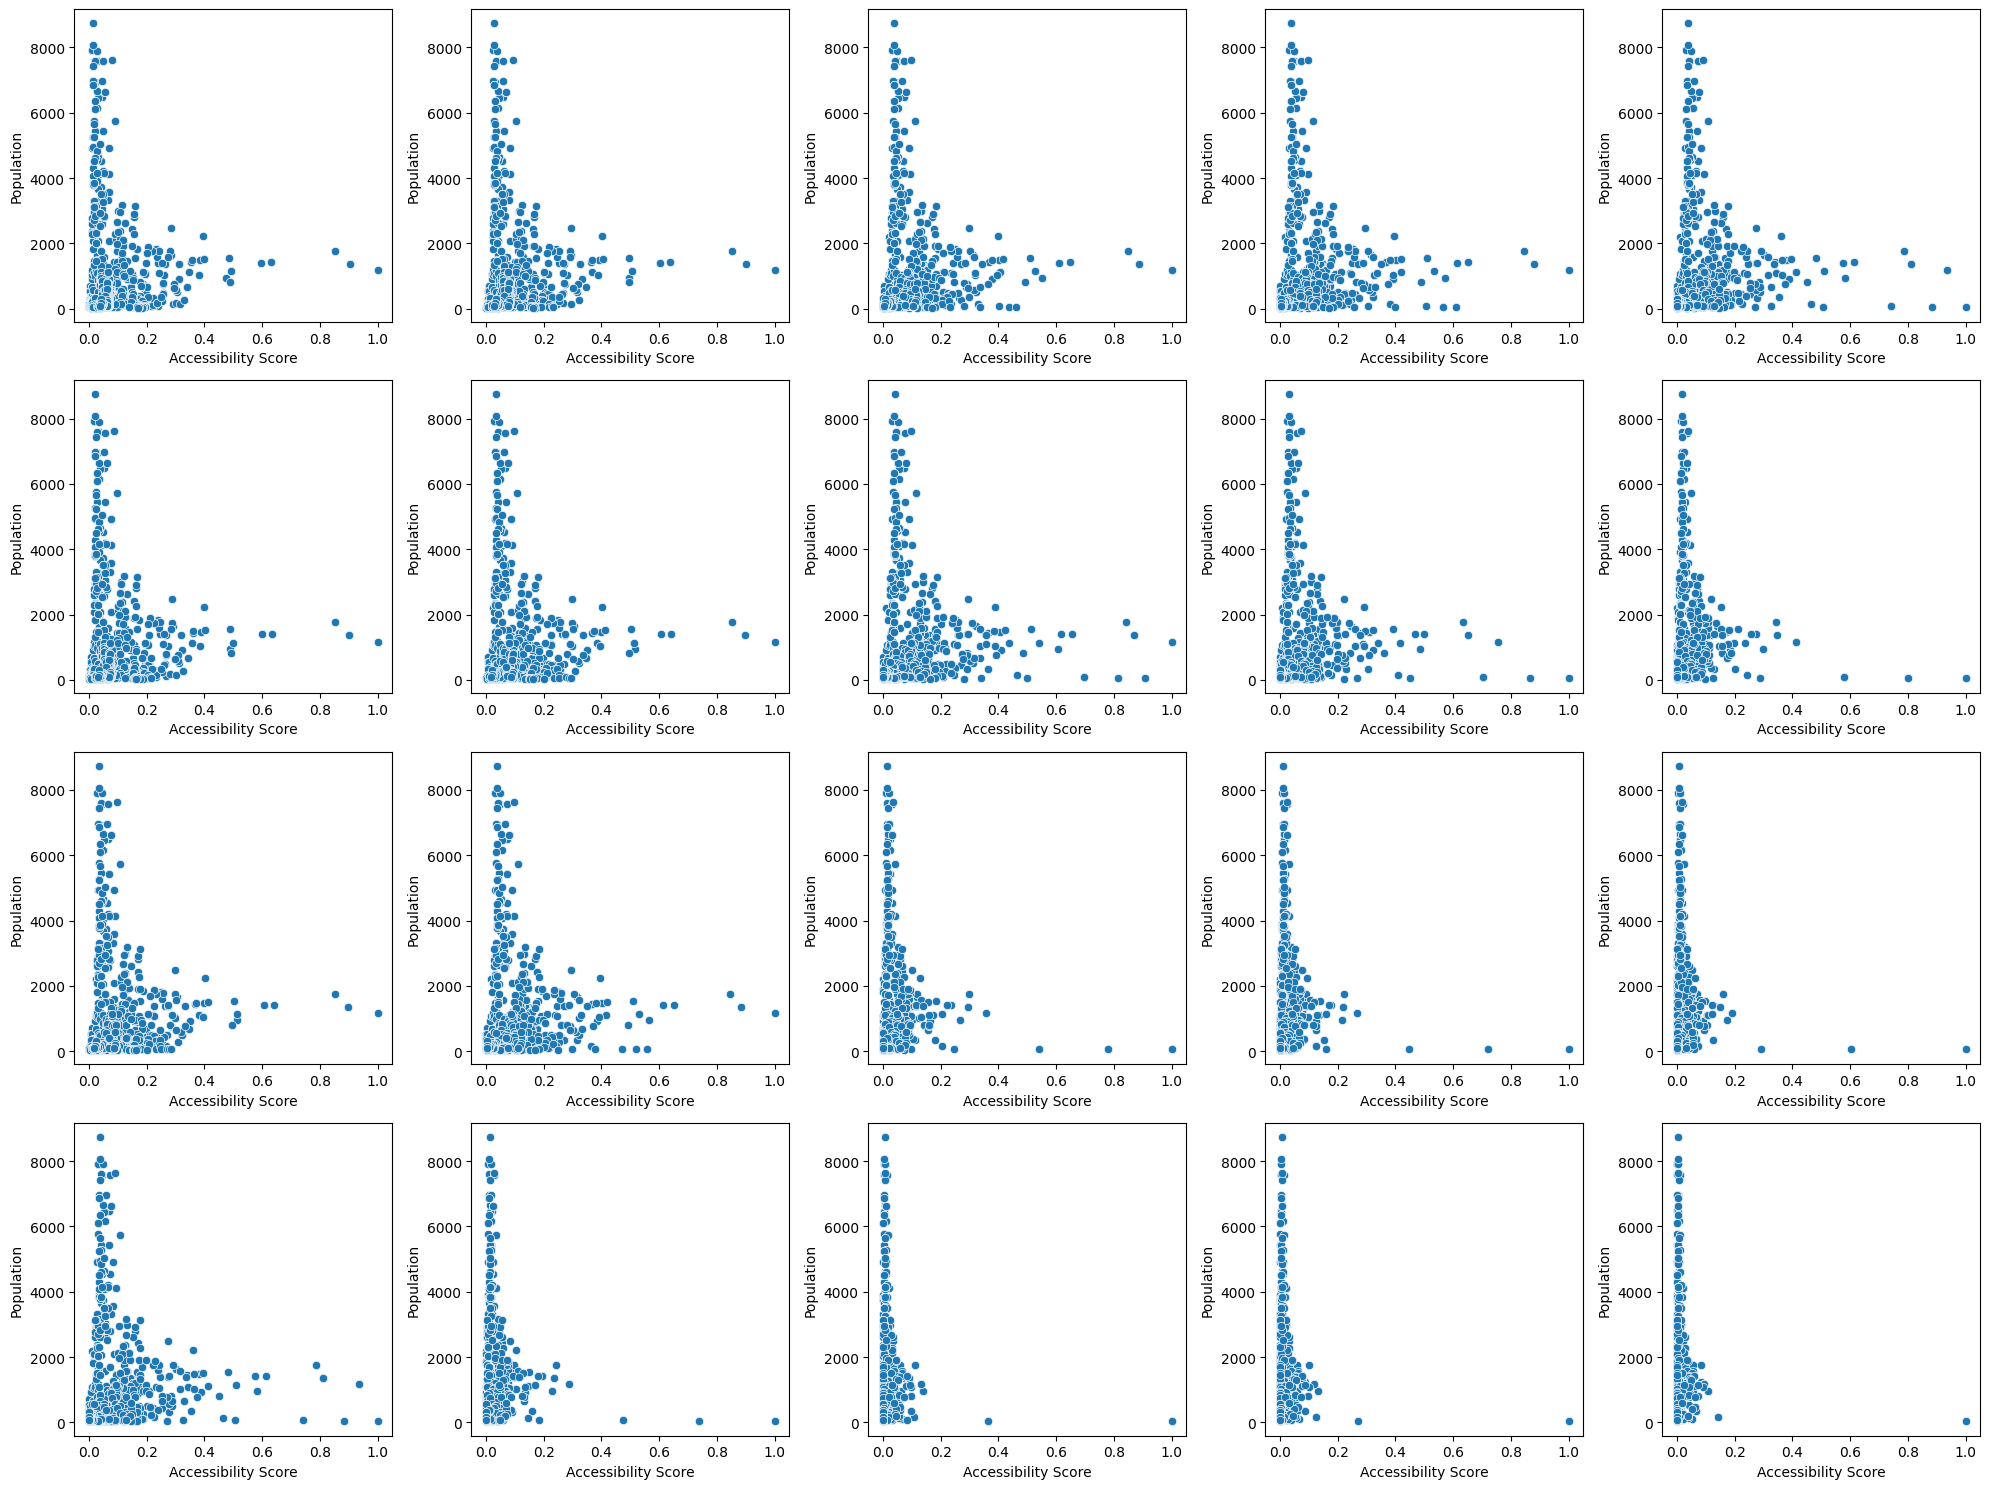

In [27]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from matplotlib import gridspec

data_folder = 'data_outputs/acc_score_3_closest_Emoc'

file_names = [f for f in os.listdir(data_folder) if f.endswith('.gpkg')] 

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 5, figure=fig)

y_labels = ['5min', '10min', '15min', '20min']
x_labels = [0.75, 0.5, 0.1, 0.05, 0.01]


for i, file_name in enumerate(file_names):
    file_path = os.path.join(data_folder, file_name)
    gdf = gpd.read_file(file_path)

    match = re.search(r'd(\d+)', file_name)
    if match:
        d_value = int(match.group(1))
        y_position = 3 - (d_value // 5 - 1)

    match = re.search(r'w(\d+\.\d+)', file_name)
    if match:
        w_value = float(match.group(1))
        x_position = x_labels.index(w_value)

    ax = fig.add_subplot(gs[y_position, x_position])
    
    sns.scatterplot(x='Accessibility_standard', y='population', data=gdf, ax=ax)
    ax.set_xlabel('Accessibility Score')
    ax.set_ylabel('Population')

plt.tight_layout()
output_image_path = 'data_outputs/output_image.png'
plt.savefig(output_image_path, bbox_inches='tight', dpi=300)

In [ ]:
plt.show()

# 4. Grouping by grid ID to prepare the final output file
There is a need to update this part of the code

In [ ]:
# Read the GeoPackage file (if starting from this section)
results_grid = gpd.read_file(data_outputs + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')
results_grid = results_grid[['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry']]





In [ ]:
# Group by multiple columns and calculate the mean for numeric columns
# results_grid = results_grid.groupby(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard']).count().reset_index()

results_grid = results_grid.drop_duplicates(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry'])

type(results_grid)

In [ ]:
results_grid

### Setting values for Low medium and High categories

We started by defining equal value division, and modified the thesholds to a value that is more legible and easier to interpret. Every model should have their own thresholds based on the data distribution of the three categories. 

Note: For Kano, we excluded grid cells with index values below 0.000001 that indicated very low population and a small number of buildings.  

In [ ]:
results_grid['result'] = -1
results_grid.loc[results_grid['Accessibility_standard'] > 0.000001, 'result'] = 2
results_grid.loc[results_grid['Accessibility_standard'] > 0.005, 'result'] = 1
results_grid.loc[results_grid['Accessibility_standard'] > 0.02, 'result'] = 0

### Setting values for focus areas

We defined the focus areas based on values for the different thresholds. We aim at participants helping us to confirm the selection of the city-specific thresholds.

In [ ]:
results_grid['focused'] = 0
# Focus areas between the Low category and the excluded cells due to low population or no buildings
results_grid.loc[(results_grid['Accessibility_standard'] > 0.000001) & (results_grid['Accessibility_standard'] < 0.0000015), 'focused'] = 1
# Focus areas between the Medium and High categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.003) & (results_grid['Accessibility_standard'] < 0.006), 'focused'] = 1
# Focus areas between the Low and Medium categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.019) & (results_grid['Accessibility_standard'] < 0.03), 'focused'] = 1

In [ ]:
results_grid

### Setting values for Low medium and High categories

We started by defining equal value division, and modified the thesholds to a value that is more legible and easier to interpret. Every model should have their own thresholds based on the data distribution of the three categories. 

Note: For Kano, we excluded grid cells with index values below 0.000001 that indicated very low population and a small number of buildings.  

In [114]:
results_grid['result'] = -1
results_grid.loc[results_grid['Accessibility_standard'] > 0.000001, 'result'] = 2
results_grid.loc[results_grid['Accessibility_standard'] > 0.005, 'result'] = 1
results_grid.loc[results_grid['Accessibility_standard'] > 0.02, 'result'] = 0



### Setting values for focus areas

We defined the focus areas based on values for the different thresholds. We aim at participants helping us to confirm the selection of the city-specific thresholds.

In [ ]:
results_grid['focused'] = 0
# Focus areas between the Low category and the excluded cells due to low population or no buildings
results_grid.loc[(results_grid['Accessibility_standard'] > 0.000001) & (results_grid['Accessibility_standard'] < 0.0000015), 'focused'] = 1
# Focus areas between the Medium and High categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.003) & (results_grid['Accessibility_standard'] < 0.006), 'focused'] = 1
# Focus areas between the Low and Medium categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.019) & (results_grid['Accessibility_standard'] < 0.03), 'focused'] = 1

results_grid

In [ ]:
results_grid = results_grid.loc[results_grid['result'] != -1]


In [121]:
results_grid = results_grid.rename(columns={
    'origin_lon': 'longitude',
    'origin_lat': 'latitude',
    'origin_lon_min': 'lon_min',
    'origin_lat_min': 'lat_min',
    'origin_lon_max': 'lon_max',
    'origin_lat_max': 'lat_max'
})

results_grid

,grid_id,longitude,latitude,lon_min,lat_min,lon_max,lat_max,Accessibility_standard,geometry,focused,result
0,1,8.301005,12.122137,8.300491,12.121729,8.301519,12.122545,0.004124,"POLYGON ((8.30051 12.12254, 8.30152 12.12254, ...",1,2
1,2,8.319272,12.072376,8.318758,12.071968,8.319786,12.072784,0.001466,"POLYGON ((8.31877 12.07278, 8.31979 12.07278, ...",0,2
2,3,8.330126,12.110716,8.329612,12.110308,8.330640,12.111124,0.021559,"POLYGON ((8.32963 12.11112, 8.33064 12.11112, ...",1,0
3,4,8.330079,12.108269,8.329565,12.107861,8.330593,12.108676,0.024239,"POLYGON ((8.32958 12.10868, 8.33059 12.10868, ...",1,0
5,8,8.397532,12.091138,8.397019,12.090730,8.398046,12.091546,0.007236,"POLYGON ((8.39703 12.09155, 8.39805 12.09155, ...",0,1
...,...,...,...,...,...,...,...,...,...,...,...
423226,148623,8.676033,11.850535,8.675520,11.850127,8.676547,11.850943,0.000001,"POLYGON ((8.67554 11.85094, 8.67655 11.85094, ...",1,2
423227,148624,8.676017,11.849719,8.675504,11.849312,8.676531,11.850127,0.000002,"POLYGON ((8.67552 11.85013, 8.67653 11.85013, ...",0,2
423228,148625,8.676001,11.848904,8.675488,11.848496,8.676515,11.849312,0.000001,"POLYGON ((8.6755 11.84931, 8.67651 11.84931, 8...",1,2
423500,148897,8.677044,11.850535,8.676531,11.850127,8.677558,11.850943,0.000001,"POLYGON ((8.67655 11.85094, 8.67756 11.85094, ...",1,2


In [ ]:
# Save the results to a new GeoPackage file
output_gpkg_path = data_outputs + 'emergency-maternal-care-deprivation-access.gpkg'
results_grid.to_file(output_gpkg_path, layer='emergency-maternal-care-deprivation-access', driver='GPKG')

# Save the results to a CSV file in the format required by the IDEAMAPS data ecosystem
results_table = results_grid.drop(columns=['Accessibility_standard', 'grid_id', 'geometry'])
results_table.to_csv(model_outputs + 'model-output.csv', index=False)

In [ ]:
results_table